In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataloading

In [2]:
import json

categorical_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
solutions_df = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# load categorical labels
with open("categorical_labels.json", "r") as file:
    categorical_labels = json.load(file)

# json cant store keys of type int, cast int keys back to int
categorical_labels = {category: {int(key): label for key, label in mapping.items()} for category, mapping in categorical_labels.items()}

## Data Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import StandardScaler

df = pd.merge(categorical_df, quantitative_df, on="participant_id", how="inner")
df = pd.merge(df, solutions_df, on="participant_id", how="inner")

X = df.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
y = df["ADHD_Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Training

In [13]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': np.linspace(0.5, 1.0, 5)
}

# heuristic in xgboost docs used for overcoming class imbalances
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(objective='binary:logistic', scale_pos_weight=class_ratio)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

print(f'''
Best set of hyperparameters: {grid.best_params_}
Best score: {grid.best_score_}
''')


Best set of hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': np.float64(0.5)}
Best score: 0.8420270105970636



## Evaluation

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

y_pred = grid.best_estimator_.predict(X_test)

score = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f'''
Test score: {score:.3f}

Classification Report:
{report}
''')


Test score: 0.768

Classification Report:
              precision    recall  f1-score   support

           0      0.626     0.740     0.679        77
           1      0.868     0.795     0.830       166

    accuracy                          0.778       243
   macro avg      0.747     0.768     0.754       243
weighted avg      0.792     0.778     0.782       243




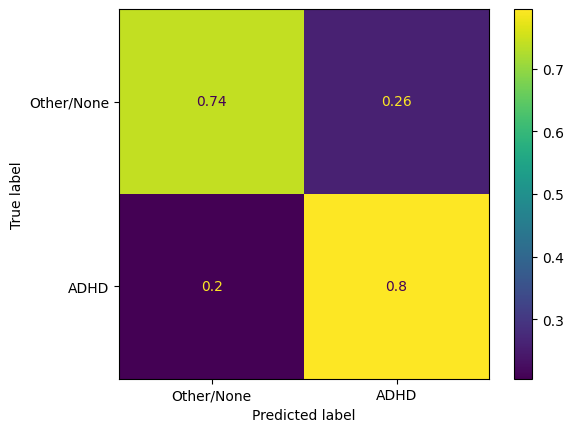

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=categorical_labels['ADHD_Outcome'].values())
plt.show()

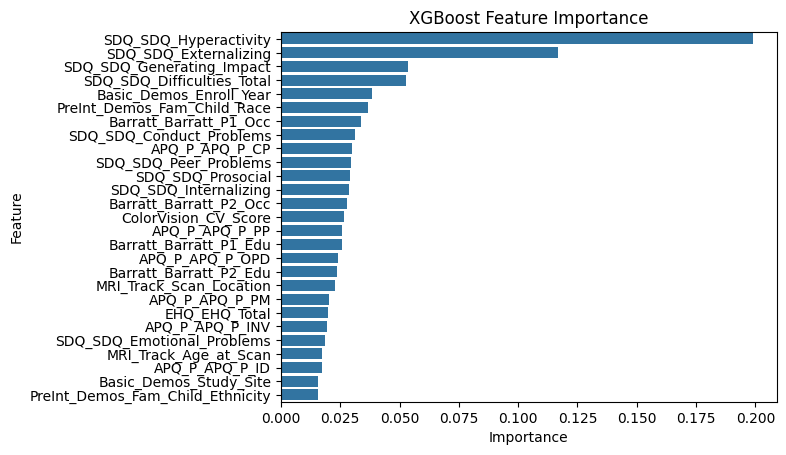

In [16]:
feature_importance_df = pd.DataFrame({
    'Importance': grid.best_estimator_.feature_importances_,
    'Feature': X.columns
}).sort_values(by='Importance', ascending=False)

plt.title('XGBoost Feature Importance')
sns.barplot(feature_importance_df, x='Importance', y='Feature')
plt.show()